*Source of the case study:* https://8weeksqlchallenge.com/case-study-7/

---

## Case Study #7 - Balanced Tree Clothing Co.

**Introduction**
<br>Balanced Tree Clothing Company prides themselves on providing an optimised range of clothing and lifestyle wear for the modern adventurer!

Danny, the CEO of this trendy fashion company has asked you to assist the team’s merchandising teams analyse their sales performance and generate a basic financial report to share with the wider business.

**Available Data**
<br>There is a total of 4 datasets for this case study - however you will only need to utilise 2 main tables to solve all of the regular questions, and the additional 2 tables are used only for the bonus challenge question!

**Product Details**
<br>`balanced_tree.product_details` includes all information about the entire range that Balanced Clothing sells in their store.

**Product Sales**
<br>`balanced_tree.sales` contains product level information for all the transactions made for Balanced Tree including quantity, price, percentage discount, member status, a transaction ID and also the transaction timestamp.

**Product Hierarcy & Product Price**
<br>Thes tables are used only for the bonus question where we will use them to recreate the `balanced_tree.product_details` table.

All datasets exist within the `balanced_tree` database schema, that you can find [here](https://github.com/etsar/SQL-practice/blob/main/SQL_case_study_7%20-%20Balanced%20Tree%20Clothing%20Co/SQL_case_study_7_DBschema.ipynb).

**Case Study Questions**

The following questions can be considered key business questions and metrics that the Balanced Tree team requires for their monthly reports.

Each question can be answered using a single query - but as you are writing the SQL to solve each individual problem, keep in mind how you would generate all of these metrics in a single SQL script which the Balanced Tree team can run each month.

**1. High Level Sales Analysis**
1. What was the total quantity sold for all products?
1. What is the total generated revenue for all products before discounts?
1. What was the total discount amount for all products?

**2. Transaction Analysis**
1. How many unique transactions were there?
1. What is the average unique products purchased in each transaction?
1. What are the 25th, 50th and 75th percentile values for the revenue per transaction?
1. What is the average discount value per transaction?
1. What is the percentage split of all transactions for members vs non-members?
1. What is the average revenue for member transactions and non-member transactions?

**3. Product Analysis**
1. What are the top 3 products by total revenue before discount?
1. What is the total quantity, revenue and discount for each segment?
1. What is the top selling product for each segment?
1. What is the total quantity, revenue and discount for each category?
1. What is the top selling product for each category?
1. What is the percentage split of revenue by product for each segment?
1. What is the percentage split of revenue by segment for each category?
1. What is the percentage split of total revenue by category?
1. What is the total transaction “penetration” for each product? (hint: penetration = number of transactions where at least 1 quantity of a product was purchased divided by total number of transactions)
1. What is the most common combination of at least 1 quantity of any 3 products in a 1 single transaction?

**4. Reporting Challenge**
<br>Write a single SQL script that combines all of the previous questions into a scheduled report that the Balanced Tree team can run at the beginning of each month to calculate the previous month’s values.

Imagine that the Chief Financial Officer (which is also Danny) has asked for all of these questions at the end of every month.

He first wants you to generate the data for January only - but then he also wants you to demonstrate that you can easily run the same analysis for February without many changes (if at all).

Feel free to split up your final outputs into as many tables as you need - but be sure to explicitly reference which table outputs relate to which question for full marks :)

**5. Bonus Challenge**
<br>Use a single SQL query to transform the `product_hierarchy` and `product_prices` datasets to the `product_details` table.

Hint: you may want to consider using a recursive CTE to solve this problem!

---

**1. High Level Sales Analysis**

**1.1. What was the total quantity sold for all products?**

**Query #1**

    SELECT SUM(qty) AS sold_products_qty
    FROM balanced_tree.sales;

| sold_products_qty |
| ----------------- |
| 45216             |

---

**1.2. What is the total generated revenue for all products before discounts?**

**Query #2**

    SELECT SUM(qty * price) AS total_revenue_before_discounts
    FROM balanced_tree.sales;

| total_revenue_before_discounts |
| ------------------------------ |
| 1289453                        |

---

**1.3. What was the total discount amount for all products?**

**Query #3**

    SELECT ROUND(SUM(qty * price * discount::numeric/100), 2) AS total_discount
    FROM balanced_tree.sales;

| total_discount |
| -------------- |
| 156229.14      |

---

**2. Transaction Analysis**

**2.1. How many unique transactions were there?**

**Query #4**

    SELECT COUNT(DISTINCT txn_id) AS transactions_cnt
    FROM balanced_tree.sales;

| transactions_cnt |
| ---------------- |
| 2500             |

---

**2.2. What is the average unique products purchased in each transaction?**

**Query #5**

    SELECT ROUND(AVG(product_txn_qty)) AS avg_products_qty
    FROM (SELECT DISTINCT txn_id, 
                 COUNT(prod_id) OVER (PARTITION BY txn_id) AS product_txn_qty
    	  FROM balanced_tree.sales) t;

| avg_products_qty |
| ---------------- |
| 6                |

---

**2.3. What are the 25th, 50th and 75th percentile values for the revenue per transaction?**

**Query #6**

    WITH t AS
    (SELECT txn_id,
     		SUM(qty * price) AS transaction_revenue
     FROM balanced_tree.sales
     GROUP BY 1)
    SELECT percentile_cont(0.25) WITHIN GROUP (ORDER BY transaction_revenue) AS revenue_25percentile,
           percentile_cont(0.5) WITHIN GROUP (ORDER BY transaction_revenue) AS revenue_50percentile,
           percentile_cont(0.75) WITHIN GROUP (ORDER BY transaction_revenue) AS revenue_75percentile
    FROM t;

| revenue_25percentile | revenue_50percentile | revenue_75percentile |
| -------------------- | -------------------- | -------------------- |
| 375.75               | 509.5                | 647                  |

---

**2.4. What is the average discount value per transaction?**

**Query #7**

    WITH t AS
    (SELECT txn_id,
    	    SUM(qty * price * discount::numeric/100) AS txn_discount
     FROM balanced_tree.sales
     GROUP BY 1)
    SELECT ROUND(AVG(txn_discount), 2) AS avg_txn_discount
    FROM t;

| avg_txn_discount |
| ---------------- |
| 62.49            |

---

**2.5. What is the percentage split of all transactions for members vs non-members?**

**Query #8**

    SELECT member,
    	   ROUND(100*COUNT(member)::numeric / (SELECT COUNT(member) FROM balanced_tree.sales), 2) AS member_percentage  
    FROM balanced_tree.sales
    GROUP BY 1;

| member | member_percentage |
| ------ | ----------------- |
| false  | 39.97             |
| true   | 60.03             |

---

**2.6. What is the average revenue for member transactions and non-member transactions?**

**Query #9**

    SELECT member,
    	   SUM(qty * price) AS total_revenue_before_discounts 
    FROM balanced_tree.sales
    GROUP BY 1;

| member | total_revenue_before_discounts |
| ------ | ------------------------------ |
| false  | 512469                         |
| true   | 776984                         |

Therefore, over 60% of revenue (before discounts) came from members, which is in line with the percentage split of all transactions for members vs non-members from the previous query.

---

**3. Product Analysis**

**3.1. What are the top 3 products by total revenue before discount?**

**Query #10**

    SELECT prod_id,
    	   product_name,
    	   SUM(qty * s.price) AS total_revenue_before_discounts 
    FROM balanced_tree.sales s
    LEFT JOIN balanced_tree.product_details p ON s.prod_id = p.product_id
    GROUP BY 1, 2
    ORDER BY 3 DESC
    LIMIT 3;

| prod_id | product_name                 | total_revenue_before_discounts |
| ------- | ---------------------------- | ------------------------------ |
| 2a2353  | Blue Polo Shirt - Mens       | 217683                         |
| 9ec847  | Grey Fashion Jacket - Womens | 209304                         |
| 5d267b  | White Tee Shirt - Mens       | 152000                         |

---

**3.2. What is the total quantity, revenue and discount for each segment?**

**Query #11**

    SELECT segment_id,
    	   segment_name,
           SUM(qty) AS total_qty,
    	   SUM(qty * s.price) AS total_revenue_before_discounts,
           ROUND(SUM(qty * s.price * discount::numeric/100), 2) AS total_discount
    FROM balanced_tree.sales s
    LEFT JOIN balanced_tree.product_details p ON s.prod_id = p.product_id
    GROUP BY 1, 2
    ORDER BY 1;

| segment_id | segment_name | total_qty | total_revenue_before_discounts | total_discount |
| ---------- | ------------ | --------- | ------------------------------ | -------------- |
| 3          | Jeans        | 11349     | 208350                         | 25343.97       |
| 4          | Jacket       | 11385     | 366983                         | 44277.46       |
| 5          | Shirt        | 11265     | 406143                         | 49594.27       |
| 6          | Socks        | 11217     | 307977                         | 37013.44       |

From the table above we can see that most of the items sold were in the `Jacket` segment, but the highest revenue (before and after discounts) was in the `Shirt` segment. 

---

**3.3. What is the top selling product for each segment?**

**Query #12**

    WITH t AS
    (SELECT segment_id,
    	    segment_name,
            product_id,
            product_name,
            SUM(qty) AS total_qty,
            RANK() OVER (PARTITION BY segment_id ORDER BY SUM(qty) DESC) AS qty_rank
    FROM balanced_tree.sales s
    LEFT JOIN balanced_tree.product_details p ON s.prod_id = p.product_id
    GROUP BY 1, 2, 3, 4)
    
    SELECT segment_id,
    	   segment_name,
           product_id,
           product_name,
           total_qty
    FROM t
    WHERE qty_rank=1;

| segment_id | segment_name | product_id | product_name                  | total_qty |
| ---------- | ------------ | ---------- | ----------------------------- | --------- |
| 3          | Jeans        | c4a632     | Navy Oversized Jeans - Womens | 3856      |
| 4          | Jacket       | 9ec847     | Grey Fashion Jacket - Womens  | 3876      |
| 5          | Shirt        | 2a2353     | Blue Polo Shirt - Mens        | 3819      |
| 6          | Socks        | f084eb     | Navy Solid Socks - Mens       | 3792      |

---

**3.4. What is the total quantity, revenue and discount for each category?**

**Query #13**

    SELECT category_id,
    	   category_name,
           SUM(qty) AS total_qty,
    	   SUM(qty * s.price) AS total_revenue_before_discounts,
           ROUND(SUM(qty * s.price * discount::numeric/100), 2) AS total_discount
    FROM balanced_tree.sales s
    LEFT JOIN balanced_tree.product_details p ON s.prod_id = p.product_id
    GROUP BY 1, 2
    ORDER BY 1;

| category_id | category_name | total_qty | total_revenue_before_discounts | total_discount |
| ----------- | ------------- | --------- | ------------------------------ | -------------- |
| 1           | Womens        | 22734     | 575333                         | 69621.43       |
| 2           | Mens          | 22482     | 714120                         | 86607.71       |

As we can see, there is no much difference between the two categories in quantity, but revenue in `Mens` category is higher (over 55% in comparison with around 45% in `Womens` category). Probably, the price of items in `Mens` category is higher.

---

**3.5. What is the top selling product for each category?**

**Query #14**

    WITH t AS
    (SELECT category_id,
    	    category_name,
            product_id,
            product_name,
            SUM(qty) AS total_qty,
            RANK() OVER (PARTITION BY category_id ORDER BY SUM(qty) DESC) AS qty_rank
    FROM balanced_tree.sales s
    LEFT JOIN balanced_tree.product_details p ON s.prod_id = p.product_id
    GROUP BY 1, 2, 3, 4)
    
    SELECT category_id,
    	   category_name,
           product_id,
           product_name,
           total_qty
    FROM t
    WHERE qty_rank=1;

| category_id | category_name | product_id | product_name                 | total_qty |
| ----------- | ------------- | ---------- | ---------------------------- | --------- |
| 1           | Womens        | 9ec847     | Grey Fashion Jacket - Womens | 3876      |
| 2           | Mens          | 2a2353     | Blue Polo Shirt - Mens       | 3819      |

---

**3.6. What is the percentage split of revenue by product for each segment?**

**Query #15**

    WITH t AS
    (SELECT segment_id,
    	    segment_name,
            product_id,
            product_name,
    	    SUM(qty * s.price) AS total_revenue_before_discounts
    FROM balanced_tree.sales s
    LEFT JOIN balanced_tree.product_details p ON s.prod_id = p.product_id
    GROUP BY 1, 2, 3, 4)
    
    SELECT *,
    	   ROUND(100*total_revenue_before_discounts / (SUM(total_revenue_before_discounts) OVER (PARTITION BY segment_id)), 2) AS revenue_percentage
    FROM t
    ORDER BY segment_id, revenue_percentage DESC;

| segment_id | segment_name | product_id | product_name                     | total_revenue_before_discounts | revenue_percentage |
| ---------- | ------------ | ---------- | -------------------------------- | ------------------------------ | ------------------ |
| 3          | Jeans        | e83aa3     | Black Straight Jeans - Womens    | 121152                         | 58.15              |
| 3          | Jeans        | c4a632     | Navy Oversized Jeans - Womens    | 50128                          | 24.06              |
| 3          | Jeans        | e31d39     | Cream Relaxed Jeans - Womens     | 37070                          | 17.79              |
| 4          | Jacket       | 9ec847     | Grey Fashion Jacket - Womens     | 209304                         | 57.03              |
| 4          | Jacket       | d5e9a6     | Khaki Suit Jacket - Womens       | 86296                          | 23.51              |
| 4          | Jacket       | 72f5d4     | Indigo Rain Jacket - Womens      | 71383                          | 19.45              |
| 5          | Shirt        | 2a2353     | Blue Polo Shirt - Mens           | 217683                         | 53.60              |
| 5          | Shirt        | 5d267b     | White Tee Shirt - Mens           | 152000                         | 37.43              |
| 5          | Shirt        | c8d436     | Teal Button Up Shirt - Mens      | 36460                          | 8.98               |
| 6          | Socks        | f084eb     | Navy Solid Socks - Mens          | 136512                         | 44.33              |
| 6          | Socks        | 2feb6b     | Pink Fluro Polkadot Socks - Mens | 109330                         | 35.50              |
| 6          | Socks        | b9a74d     | White Striped Socks - Mens       | 62135                          | 20.18              |

The largest revenue share in the `Jeans` segment had `Black Straight Jeans - Womens` item - over 58% of revenue for this segment.
<br>In the `Jacket` segment - `Grey Fashion Jacket - Womens` item - over 57% of revenue for this segment.
<br>In the `Shirt` segment - `Blue Polo Shirt - Mens` item - around 54% of revenue for this segment.
<br>In the `Socks` segment - `Navy Solid Socks - Mens` item - over 44% of revenue for this segment.

---

**3.7. What is the percentage split of revenue by segment for each category?**

**Query #16**

    WITH t AS
    (SELECT category_id,
    	    category_name,
            segment_id,
    	    segment_name,
    	    SUM(qty * s.price) AS total_revenue_before_discounts
    FROM balanced_tree.sales s
    LEFT JOIN balanced_tree.product_details p ON s.prod_id = p.product_id
    GROUP BY 1, 2, 3, 4)
    
    SELECT *,
    	   ROUND(100*total_revenue_before_discounts / (SUM(total_revenue_before_discounts) OVER (PARTITION BY category_id)), 2) AS revenue_percentage
    FROM t
    ORDER BY category_id, revenue_percentage DESC;

| category_id | category_name | segment_id | segment_name | total_revenue_before_discounts | revenue_percentage |
| ----------- | ------------- | ---------- | ------------ | ------------------------------ | ------------------ |
| 1           | Womens        | 4          | Jacket       | 366983                         | 63.79              |
| 1           | Womens        | 3          | Jeans        | 208350                         | 36.21              |
| 2           | Mens          | 5          | Shirt        | 406143                         | 56.87              |
| 2           | Mens          | 6          | Socks        | 307977                         | 43.13              |

Therefore, the largest revenue share in the `Womens` category had `Jacket` segment - around 64%.
<br>In the `Mens` category the largest revenue share had `Shirt` segment - around 57%.

---

**3.8. What is the percentage split of total revenue by category?**

**Query #17**

    SELECT category_id,
    	   category_name,
    	   ROUND(100*SUM(qty * s.price)::numeric / (SELECT SUM(qty * price) FROM balanced_tree.sales), 2) AS revenue_percentage
    FROM balanced_tree.sales s
    LEFT JOIN balanced_tree.product_details p ON s.prod_id = p.product_id
    GROUP BY 1, 2;

| category_id | category_name | revenue_percentage |
| ----------- | ------------- | ------------------ |
| 2           | Mens          | 55.38              |
| 1           | Womens        | 44.62              |

---

**3.9. What is the total transaction “penetration” for each product? (hint: penetration = number of transactions where at least 1 quantity of a product was purchased divided by total number of transactions)**

**Query #18**

    SELECT prod_id,
    	   product_name,
    	   ROUND(COUNT(txn_id)::numeric / (SELECT COUNT(DISTINCT txn_id) FROM balanced_tree.sales), 3) AS txn_penetration
    FROM balanced_tree.sales s
    LEFT JOIN balanced_tree.product_details p ON s.prod_id = p.product_id
    GROUP BY 1, 2;

| prod_id | product_name                     | txn_penetration |
| ------- | -------------------------------- | --------------- |
| 2a2353  | Blue Polo Shirt - Mens           | 0.507           |
| 2feb6b  | Pink Fluro Polkadot Socks - Mens | 0.503           |
| 5d267b  | White Tee Shirt - Mens           | 0.507           |
| 72f5d4  | Indigo Rain Jacket - Womens      | 0.500           |
| 9ec847  | Grey Fashion Jacket - Womens     | 0.510           |
| b9a74d  | White Striped Socks - Mens       | 0.497           |
| c4a632  | Navy Oversized Jeans - Womens    | 0.510           |
| c8d436  | Teal Button Up Shirt - Mens      | 0.497           |
| d5e9a6  | Khaki Suit Jacket - Womens       | 0.499           |
| e31d39  | Cream Relaxed Jeans - Womens     | 0.497           |
| e83aa3  | Black Straight Jeans - Womens    | 0.498           |
| f084eb  | Navy Solid Socks - Mens          | 0.512           |

---

**3.10. What is the most common combination of at least 1 quantity of any 3 products in a 1 single transaction?**

In order to answer this question we need to count **the frequency of all possible combinations of any 3 products in a single transaction**.
<br>Since the order of the product items doesn't matter, we can use the following formula to identify the number of combinations of `k` elements out of `n` total elements without repetition: 
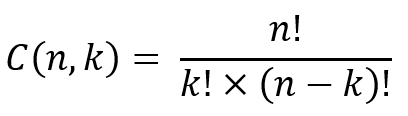
<br>So, in our case we need to find the number of combinations of any 3 products **(k=3)** out of 12 unique products **(n=12)**. Therefore, **there are 220 possible combinations of products**!

Let's go over all possible combinations by joining `balanced_tree.sales` table to itself 2 times, meaning that we'll combine data from **3 tables** (as we need a combination of **3 items in a transaction**), and then calculate the frequency:

**Query #19**

    SELECT s.prod_id, t1.prod_id, t2.prod_id, COUNT(*) AS combination_cnt	   
    FROM balanced_tree.sales s
    JOIN balanced_tree.sales t1 ON t1.txn_id = s.txn_id 
    AND s.prod_id < t1.prod_id
    JOIN balanced_tree.sales t2 ON t2.txn_id = s.txn_id
    AND t1.prod_id < t2.prod_id
    GROUP BY 1, 2, 3
    ORDER BY 4 DESC
    LIMIT 1;

| prod_id | prod_id | prod_id | combination_cnt |
| ------- | ------- | ------- | --------------- |
| 5d267b  | 9ec847  | c8d436  | 352             |

As we can see from the table above, the most common combination of any 3 products in 1 transaction is 5d267b, 9ec847 and c8d436. This combination occured **352 times**.

You can find the entire output for all of 220 possible combinations [here](https://github.com/etsar/SQL-practice/blob/main/SQL_case_study_7%20-%20Balanced%20Tree%20Clothing%20Co/SQL_case_study_7_possible_combinations.ipynb).

---

**4. Reporting Challenge**

Write a single SQL script that combines all of the previous questions into a scheduled report that the Balanced Tree team can run at the beginning of each month to calculate the previous month’s values.

Imagine that the Chief Financial Officer (which is also Danny) has asked for all of these questions at the end of every month.

He first wants you to generate the data for January only - but then he also wants you to demonstrate that you can easily run the same analysis for February without many changes (if at all).

Feel free to split up your final outputs into as many tables as you need - but be sure to explicitly reference which table outputs relate to which question for full marks :)

You can find a single SQL script that combines all of the questions into a scheduled report that the Balanced Tree team can run at the beginning of each month to calculate the previous month’s values [here](https://github.com/etsar/SQL-practice/blob/main/SQL_case_study_7%20-%20Balanced%20Tree%20Clothing%20Co/SQL_case_study_7_monthly_report_script.ipynb).

---

**Bonus Challenge**

Use a single SQL query to transform the `product_hierarchy` and `product_prices` datasets to the `product_details` table.
Hint: you may want to consider using a recursive CTE to solve this problem!

**Query #20**

    WITH t AS
    (SELECT h.id AS style_id, 
    	    h.level_text AS style_name, 
            t1.id AS segment_id, 
            t1.level_text AS segment_name,
            t1.parent_id AS category_id,
            t2.level_text AS category_name
    FROM balanced_tree.product_hierarchy h
    LEFT JOIN balanced_tree.product_hierarchy t1 ON h.parent_id=t1.id
    LEFT JOIN balanced_tree.product_hierarchy t2 ON t1.parent_id=t2.id
    WHERE h.id BETWEEN 7 AND 18)
    
    SELECT p.product_id,
    	   p.price,
           CONCAT(t.style_name, ' ', t.segment_name, ' - ', t.category_name) AS product_name,
           t.category_id,
           t.segment_id,
           t.style_id,
           t.category_name,
           t.segment_name,
           t.style_name
    FROM balanced_tree.product_prices p
    LEFT JOIN t ON p.id = t.style_id;

| product_id | price | product_name                     | category_id | segment_id | style_id | category_name | segment_name | style_name          |
| ---------- | ----- | -------------------------------- | ----------- | ---------- | -------- | ------------- | ------------ | ------------------- |
| c4a632     | 13    | Navy Oversized Jeans - Womens    | 1           | 3          | 7        | Womens        | Jeans        | Navy Oversized      |
| e83aa3     | 32    | Black Straight Jeans - Womens    | 1           | 3          | 8        | Womens        | Jeans        | Black Straight      |
| e31d39     | 10    | Cream Relaxed Jeans - Womens     | 1           | 3          | 9        | Womens        | Jeans        | Cream Relaxed       |
| d5e9a6     | 23    | Khaki Suit Jacket - Womens       | 1           | 4          | 10       | Womens        | Jacket       | Khaki Suit          |
| 72f5d4     | 19    | Indigo Rain Jacket - Womens      | 1           | 4          | 11       | Womens        | Jacket       | Indigo Rain         |
| 9ec847     | 54    | Grey Fashion Jacket - Womens     | 1           | 4          | 12       | Womens        | Jacket       | Grey Fashion        |
| 5d267b     | 40    | White Tee Shirt - Mens           | 2           | 5          | 13       | Mens          | Shirt        | White Tee           |
| c8d436     | 10    | Teal Button Up Shirt - Mens      | 2           | 5          | 14       | Mens          | Shirt        | Teal Button Up      |
| 2a2353     | 57    | Blue Polo Shirt - Mens           | 2           | 5          | 15       | Mens          | Shirt        | Blue Polo           |
| f084eb     | 36    | Navy Solid Socks - Mens          | 2           | 6          | 16       | Mens          | Socks        | Navy Solid          |
| b9a74d     | 17    | White Striped Socks - Mens       | 2           | 6          | 17       | Mens          | Socks        | White Striped       |
| 2feb6b     | 29    | Pink Fluro Polkadot Socks - Mens | 2           | 6          | 18       | Mens          | Socks        | Pink Fluro Polkadot |

---